In [27]:
import sys,os
import obspy
from obspy.taup import TauPyModel
import numpy as np
import matplotlib.pyplot as plt
import pygmt
import pandas as pd

import time

########### 
import bp_lib
import math
def calculate_shear_mach_front_angle(super_shear_velocity):
    # Calculate the shear Mach front angle using the super-shear velocity
    sin_shear_mach_front_angle = 1 / super_shear_velocity
    shear_mach_front_angle = math.degrees(math.asin(sin_shear_mach_front_angle))
    return shear_mach_front_angle

name='EAF_7.8_alongstrike_AL_10.0km_ak135_0.7_corr_0.5_grid'
#name='EAF_7.8_alongstrike_AL_10.0km_ak135_0.7_corr_0.5_grid'
#name='EAF_7.8_all_sta_alongstrike_AL_10.0km_ak135_0.0_corr_0.1_grid'
#name='EAF_7.8_no_filt_AL_10.0km_ak135_0.7_corr_0.1_grid' 
outdir = name #str(Event)+'_'+str(Exp_name)
path = os.getcwd()
scale=2
peak_scale=7
bp_l=0.2
bp_u=2.5
smooth_time_window=10
smooth_space_window=10
#STF_start=0
#STF_end=30
#stack_start=30
#stack_end=200
#stack_end=100

In [37]:
input = pd.read_csv('./'+name+'/input.csv',header=None)
a=input.to_dict('series')
keys = a[0][:]
values = a[1][:]
res = {}
for i in range(len(keys)):
        res[keys[i]] = values[i]
        #print(keys[i],values[i])
#################################################################
# bp info
## BP parameters from the input file#slong,slat          = bp_lib.make_source_grid(event_long,event_lat,source_grid_extend,source_grid_size)
#slong,slat          = bp_lib.make_source_grid_hetero(event_long,event_lat,source_grid_extend_x,source_grid_extend_y,source_grid_size)

stack_start         = int(res['stack_start'])   #in seconds
stack_end           = int(res['stack_end'])  #in seconds
STF_start           = int(res['STF_start'])
STF_end             = 150 #int(res['STF_end'])  //increase to 150 from 100 
sps                 = int(res['sps'])  #samples per seconds
corr_window         = int(res['corr_window'])
threshold_correlation=float(res['threshold_correlation'])
SNR=float(res['SNR'])
#smooth_time_window=5
#smooth_space_window=5
#smooth_time_window  = int((stack_end-stack_start)/10) #int(res['smooth_time_window'])   #seconds
#STF_start=0
#STF_end=40
#stack_start=25
#stack_end=stack_start+STF_end
#bp_l=0.5
#bp_u=1.0
##########################################################################
# Event info
Event=res['Event']
event_lat=float(res['event_lat'])
event_long=float(res['event_long'])
event_depth=float(res['event_depth'])
Array_name=res['Array_name']
#Exp_name=res['Exp_name']
azimuth_min=float(res['azimuth_min'])
azimuth_max=float(res['azimuth_max'])
dist_min=float(res['dist_min'])
dist_max=float(res['dist_max'])
origin_time=obspy.UTCDateTime(int(res['origin_year']),int(res['origin_month']),
             int(res['origin_day']),int(res['origin_hour']),int(res['origin_minute']),float(res['origin_seconds']))
print(origin_time)
Focal_mech = dict(strike=float(res['event_strike']), dip=float(res['event_dip']), rake=float(res['event_rake'])
                 , magnitude=float(res['event_magnitude']))
model               = TauPyModel(model=str(res['model']))
sps                 = int(res['sps'])  #samples per seconds
corr_window         = int(res['corr_window'])
threshold_correlation=float(res['threshold_correlation'])
SNR=float(res['SNR'])
#smooth_time_window  = int((stack_end-stack_start)/10) #int(res['smooth_time_window'])   #seconds
source_grid_size    = float(res['source_grid_size']) #degrees
source_grid_extend  = float(res['source_grid_extend'])   #degrees
source_grid_extend_x  = float(res['source_grid_extend_x'])   #degrees
source_grid_extend_y  = float(res['source_grid_extend_y']) 
source_depth_size   = float(res['source_depth_size']) #km
source_depth_extend = float(res['source_grid_extend']) #km
#smooth_time_window  = 1 #int(res['smooth_time_window'])   #seconds
#smooth_space_window = 1 #int(4/source_grid_size) #source_grid_size  #int(res['smooth_space_window'])
#stream_for_bp=obspy.read('./Turky_7.6_all/stream.mseed')
#slong,slat          = bp_lib.make_source_grid(event_long,event_lat,source_grid_extend,source_grid_size)
#slong,slat          = bp_lib.make_source_grid_hetero(event_long,event_lat,source_grid_extend_x,source_grid_extend_y,source_grid_size)
slong, slat = bp_lib.make_source_grid_along_strike(58, event_lat, event_long, 400,150, 10) #makes grid of 10 km sizes

beam_file='beam_'+str(bp_l)+'_'+str(bp_u)+'_'+str(Array_name)+'.dat'
print('Beam file in :',beam_file)
stations_file = str(res['stations'])
stream_for_bp= obspy.read('./'+name+'/stream.mseed') 
beam = np.loadtxt('./'+name+'/'+beam_file)
beam_i = np.load('./'+name+'/beam_info.npy',allow_pickle=True)

stream_info = np.load('./'+name+'/array_bp_info.npy',allow_pickle=True)
print('#############################################################################\n')
print('Exp:',name)
print('Origin time:',origin_time)
print('Long= %f Lat= %f Depth= %f' % (event_long,event_lat,event_depth))
#print('bp_low= %f bp_high= %f Correlation threshold= %f SNR= %f'% (bp_l,bp_u,threshold_correlation,SNR))
print('#############################################################################\n')
stream_for_bp=bp_lib.populate_stream_info(stream_for_bp,stream_info,origin_time,event_depth,model)
Ref_station_index=bp_lib.get_ref_station(stream_for_bp)
ref_trace = stream_for_bp[Ref_station_index]
print('Computing computing station weight.')
stream_for_bp=bp_lib.stream_station_weight(stream_for_bp)
print('Done computing station weight.')
print('Done loading data')


2023-02-06T01:17:34.900000Z
Beam file in : beam_0.2_2.5_AL.dat
#############################################################################

Exp: EAF_7.8_alongstrike_AL_10.0km_ak135_0.7_corr_0.5_grid
Origin time: 2023-02-06T01:17:34.900000Z
Long= 37.020900 Lat= 37.225100 Depth= 10.000000
#############################################################################

Computing computing station weight.
Done computing station weight.
Done loading data


In [35]:
np.shape(beam),np.shape(slong),np.shape(slat)

((2511, 3000), (2511,), (2511,))

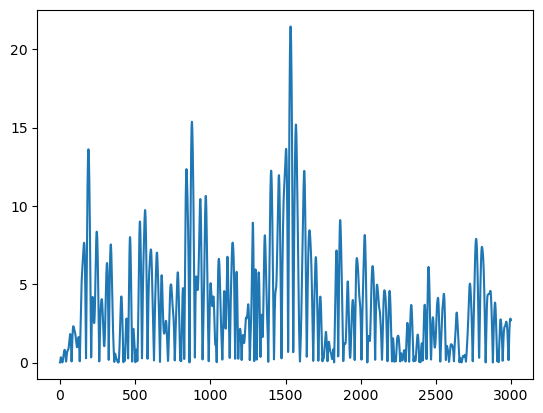

In [39]:
plt.plot(np.abs(beam[10]))

In [ ]:
smooth_beam=np.zeroes

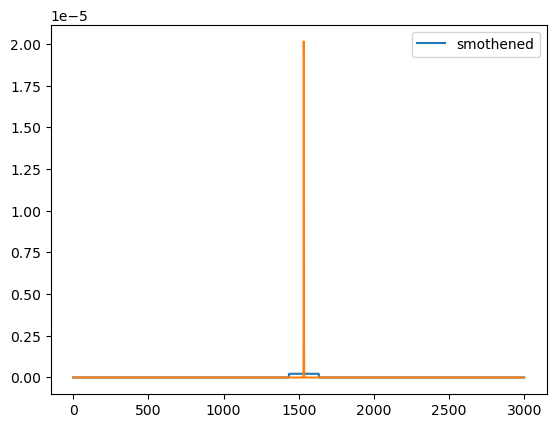

In [48]:
#beam=np.square(beam)
#beam_norm=beam/np.max(beam)
beam_smoothened_=np.zeros_like(beam)
m,n=np.shape(beam_smoothened_)
#space
for i in range(m):
    beam_smoothened_[:][i]=bp_lib.moving_average(beam[:][i],smooth_space_window)
#time
for i in range(m):
    beam_smoothened_[i][:]=bp_lib.moving_average(beam[i][:],smooth_time_window*sps)

#beam_smoothened=np.square(beam_smoothened_)/np.max(np.square(beam_smoothened_))
plt.plot(beam_smoothened_[10],label='smothened')
plt.plot(beam[10])
plt.legend()

In [31]:
# Preparing the beam i.e. getting the power
# Smoothening the beam
#beam_use=np.zeros((len(slat),(stack_end-stack_start)*sps-1))
beam=np.square(beam)
beam_smoothened_=np.zeros_like(beam)
m,n=np.shape(beam_smoothened_)
#space
for i in range(m):
    beam_smoothened_[:][i]=bp_lib.moving_average(beam[:][i],smooth_space_window)
#time
for i in range(m):
    beam_smoothened_[i][:]=bp_lib.moving_average(beam[i][:],smooth_time_window*sps)
#beam_smoothened=beam_smoothened/np.max(beam_smoothened)

beam_smoothened=np.square(beam_smoothened_)/np.max(np.square(beam_smoothened_))
print('Maximum energy of the beam:',np.max(beam_smoothened))
#plt.plot(moving_average(beam_reshaped[:][10],10*sps))

################################
# getting the STF
stf_beam      = np.sum(beam_smoothened,axis=0)
print('Size of STF:', np.shape(stf_beam))
#Taking square becaouse we are interested in the power
#stf_beam=stf_beam**2
#stf_beam=stf_beam[stack_start*sps:(stack_end)*sps]
stf_beam=stf_beam[(stack_start+STF_start)*sps:(stack_start+STF_end)*sps]

stf_beam=stf_beam/np.max(stf_beam)
print('Size of STF:', np.shape(stf_beam))
stf_beam=np.column_stack((stf_beam,range(len(stf_beam))))
stf_beam[:,1]=stf_beam[:,1]/sps
file_save    = 'STF_beam_'+str(bp_l)+'_'+str(bp_u)+'_'+str(Array_name)+'_'+str(smooth_time_window)+'_'+str(smooth_space_window)+'.dat'
np.savetxt(outdir+'/'+file_save,stf_beam,header='energy(normalized) time(s) ')  
###########################################
# Cumulative energy
beam_cumulative_use=beam_smoothened.T
#temp     =np.sum(beam_cumulative_use[stack_start*sps:(stack_end)*sps],axis=0)
temp     =np.sum(beam_cumulative_use[(stack_start+STF_start)*sps:(stack_start+STF_end)*sps],axis=0)

print('Size of the cumulative energy:',np.shape(temp))
m,n=np.shape(beam_smoothened)
cumulative_energy=np.zeros((m,3))
cumulative_energy[:,2]=temp/np.max(temp)
cumulative_energy[:,0]=slong
cumulative_energy[:,1]=slat
cumulative_energy[:,2]=cumulative_energy[:,2]/np.max(cumulative_energy[:,2])
file_save='cumulative_energy_'+str(bp_l)+'_'+str(bp_u)+'_'+str(Array_name)+'_'+str(smooth_time_window)+'_'+str(smooth_space_window)+'.dat'
np.savetxt(outdir+'/'+file_save,cumulative_energy,header='long lat energy(normalized)')
print('Maximum energy of the cumulative energy:',np.max(cumulative_energy[:,2]))
############################################################
# peak energy points
#beam_peak_energy_use=beam_smoothened.T[stack_start*sps:(stack_end)*sps]
beam_peak_energy_use=beam_smoothened.T[(stack_start+STF_start)*sps:(stack_start+STF_end)*sps]

print('Maximum energy of the beam:',np.max(beam_peak_energy_use))
m,n=np.shape(beam_peak_energy_use)
peak_energy=np.zeros((int(m/sps),4))
print('Size of the peak energy:',np.shape(peak_energy))
for i in range(len(peak_energy)):
    ind              = np.argmax(beam_peak_energy_use[i*sps])
    peak_energy[i,0] = i
    peak_energy[i,1] = slong[ind]
    peak_energy[i,2] = slat[ind]
    peak_energy[i,3] = beam_peak_energy_use[i*sps][ind]
peak_energy[:,3]=peak_energy[:,3]/np.max(peak_energy[:,3])
print('Maximum energy of the peaks:',np.max(peak_energy[:,3]))

Maximum energy of the beam: 1.0
Size of STF: (3000,)
Size of STF: (3000,)
Size of the cumulative energy: (2511,)
Maximum energy of the cumulative energy: 1.0
Maximum energy of the beam: 1.0
Size of the peak energy: (150, 4)
Maximum energy of the peaks: 1.0


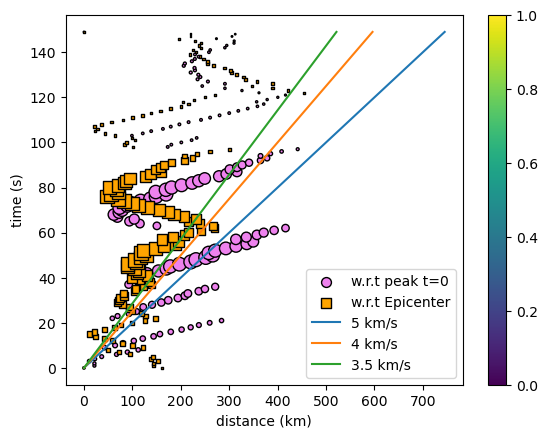

In [32]:
###############################################################
# rupture distance and velocity
dist_rupture=np.zeros(len(peak_energy)) # w.r.t to epicenter
dist_rupture2=np.zeros(len(peak_energy)) # w.r.st to the start of the peak
dist_rupture3=np.zeros(len(peak_energy)) # peak by peak
for i in range(len(dist_rupture)-1):
    dist_rupture[i]= np.sqrt(((peak_energy[i,1]-event_long)**2 + (peak_energy[i,2]-event_lat)**2))*(111)
    dist_rupture2[i]= np.sqrt(((peak_energy[i,1]-peak_energy[0,1])**2 + (peak_energy[i,2]-peak_energy[0,2])**2))*(111)
    dist_rupture3[i]= np.sqrt(((peak_energy[i+1,1]-peak_energy[i,1])**2 + (peak_energy[i+1,2]-peak_energy[i,2])**2))*(111)
peak_energy=np.column_stack((peak_energy,dist_rupture))
peak_energy=np.column_stack((peak_energy,dist_rupture2))
peak_energy=np.column_stack((peak_energy,np.cumsum(dist_rupture2)))

file_save='Peak_energy_'+str(bp_l)+'_'+str(bp_u)+'_'+str(Array_name)+'_'+str(smooth_time_window)+'_'+str(smooth_space_window)+'.dat'
np.savetxt(outdir+'/'+file_save,peak_energy,header='time(s) long lat energy(normalized) distance_wrt_epiceter(km) distance_peaks(km)')
plt.scatter(x=dist_rupture2[:], y=peak_energy[:,0],s=peak_energy[:,3]*100,c='violet',
            label='w.r.t peak t=0',marker='o',edgecolors='black')
plt.scatter(x=dist_rupture[:], y=peak_energy[:,0],s=peak_energy[:,3]*100,c='orange',
            label='w.r.t Epicenter',marker='s',edgecolors='black')
plt.plot(5.0*peak_energy[:,0],peak_energy[:,0],label='5 km/s')
plt.plot(4.0*peak_energy[:,0],peak_energy[:,0],label='4 km/s')
plt.plot(3.5*peak_energy[:,0],peak_energy[:,0],label='3.5 km/s')
#plt.plot(7*peak_energy[:,0],peak_energy[:,0],label='7 km/s')
#plt.plot(1*peak_energy[st:end,0],peak_energy[st:end,0],label='1.0 km/s')
plt.xlabel('distance (km)')
plt.ylabel('time (s)')
plt.legend()

plt.colorbar()
#plt.savefig(outdir+'/'+str(name)+'_Rupture_'+str(bp_l)+'_'+str(bp_u)+'_'+str(Array_name)+'.png')
plt.savefig(outdir+'/'+str(name)+'_Rupture_beam_sq_'+str(bp_l)+'_'+str(bp_u)+'_combined_T'+str(smooth_time_window)+'_Space'+str(smooth_space_window)+'.png')

#plt.savefig(outdir+'/'+str(name)+'_Rupture_'+str(bp_l)+'_'+str(bp_u)+'_'+str(Array_name)+'.png')

plot [WARNING]: Cannot use auto-legend -l for variable symbol size unless +S<size> is used. Option -l ignored.


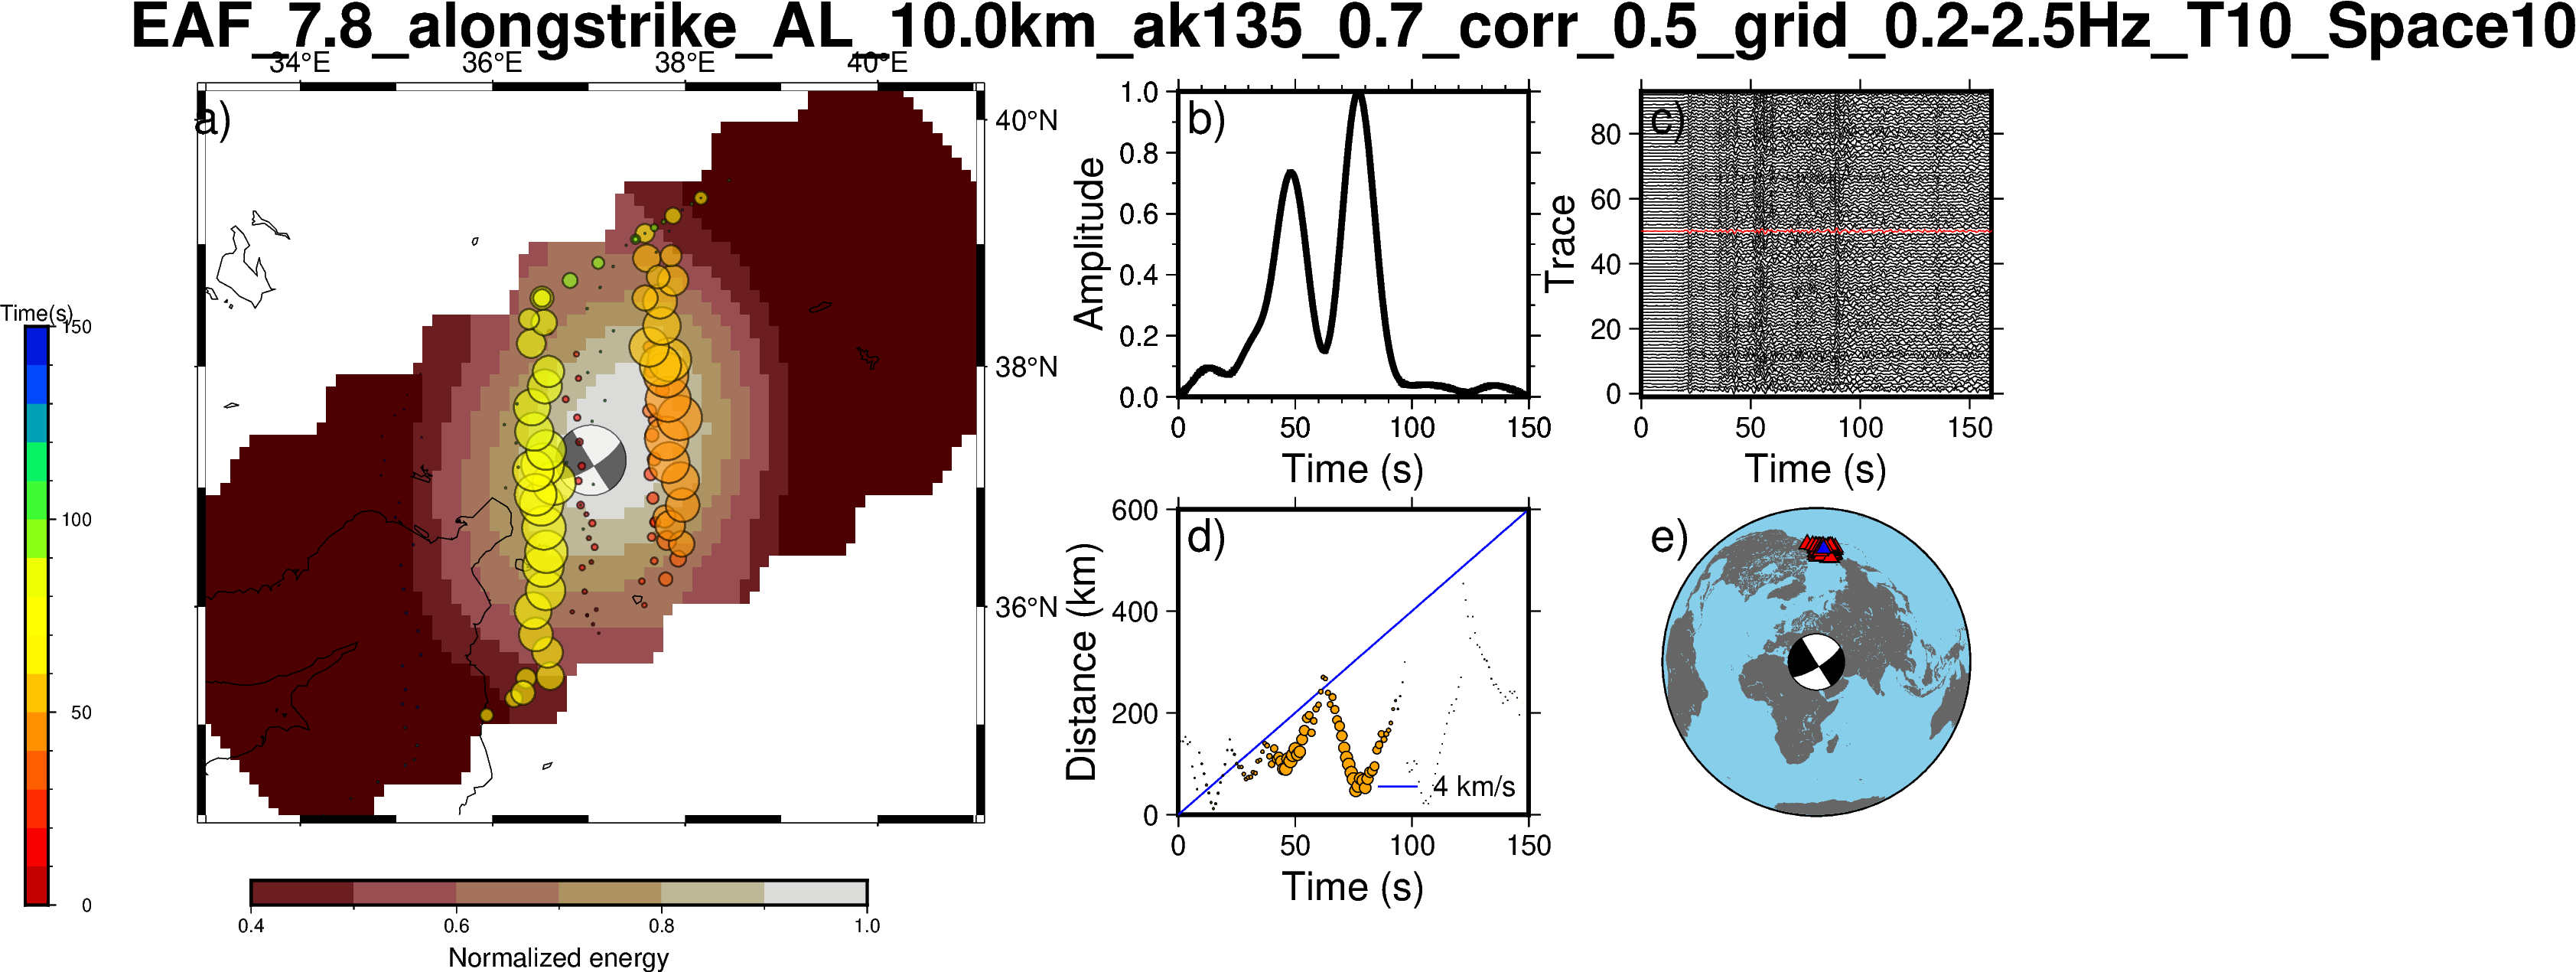

In [33]:



###################################################
# plotting
# loading other data e.g, aftershocks:
# Note that the input file name and loaction is fixed here @ajay6763- automate it
try:
    #aftershocks=np.loadtxt('./data/Myanmar/Myanmar2025-n-aftershock.txt',usecols=[4,5,6,7,8,9,10],comments='#')
    aftershocks=pd.read_csv('./data/Myanmar/Wilber_catalog.txt.txt',delimiter='|')
except:
    pass
#source_grid_extend=1
region=[event_long-source_grid_extend_x,event_long+source_grid_extend_x,event_lat-source_grid_extend_y,event_lat+source_grid_extend_y]

#region=[35.5,39,36,39]
#region=[35.5,39.5,36,38.5]
title="+t"+name+'_'+str(bp_l)+'-'+str(bp_u)+'Hz_T'+str(smooth_time_window)+'_Space'+str(smooth_space_window)
sta_lat=[]
sta_long=[]
for tr in stream_for_bp:
    sta_lat.append(tr.stats.station_latitude)
    sta_long.append(tr.stats.station_longitude)
spacing=source_grid_size
spacing=source_grid_size
fig = pygmt.Figure()
figsize=("9c", "8c")
proj="M?"
#########################################################################################################################################
# Plotting rupture map
#########################################################################################################################################
with fig.subplot(nrows=1, ncols=1, figsize=figsize, autolabel="a)",
    sharey=False,
    sharex=False,):
    energy_cmap=pygmt.makecpt(cmap="bilbao", reverse=False,series=[0.4, 1, 0.1])
    #df = pygmt.blockmean(data=cumulative_energy, region=region, spacing=spacing)
    grd_ = pygmt.xyz2grd(x=cumulative_energy[:,0],y=cumulative_energy[:,1],z=cumulative_energy[:,2],region=region, spacing=spacing)
    grd = pygmt.grdsample(grd_,spacing=0.1)
    fig.basemap(region=region,projection=proj,frame=["wNsE","af"],)
    fig.grdimage(grid=grd,cmap=energy_cmap,projection=proj, region=region, \
                 panel=[0, 0])
    fig.colorbar(cmap=energy_cmap,position="jBL+o0.5c/-1.0c+h",box=False,frame=["x+l Normalized energy "],scale=1,)
    fig.coast(shorelines=True)
    fig.meca(spec=Focal_mech,projection=proj,region=region,scale="0.5c", longitude=event_long,
             latitude=event_lat,depth=event_depth,transparency=40,)
    peak_cmap=pygmt.makecpt(cmap="seis", series=[STF_start, STF_end,  10])
    fig.plot(x=peak_energy[STF_start:STF_end,1],y=peak_energy[STF_start:STF_end,2],projection=proj,region=region, \
             fill=peak_energy[STF_start:STF_end,0],cmap=True, \
         no_clip=True,size=peak_energy[STF_start:STF_end,3]/scale,style='cc', pen='0.5p,black',transparency=40,)
    #fig.plot(x=peak_energy[:,1],y=peak_energy[:,2],projection=proj,region=region, \
    #         fill=peak_energy[:,0],cmap=True, \
    #     no_clip=True,style='c0.1', pen='0.5p,black',transparency=40,)
    try:
        fig.plot(x=aftershocks[' Longitude '],y=aftershocks[' Latitude '],
                 size=aftershocks[' Magnitude ']/20,style='ac',fill = 'black',pen='black')#,transparency=0)
    except:
        pass
   
    fig.colorbar(cmap=peak_cmap,position="jBL+o-2.0c/-1c+v",box=False,frame=["x+l ", "y+lTime(s)"],scale=1,)
    #fig.plot(x=event_long,y=event_lat,style= 'a0.5c',fill = 'blue',pen='black',)
    #fig.legend()
#########################################################################################################################################
# Left, two subplots
# Move plot origin by 1 cm above the height of the entire figure
#########################################################################################################################################
fig.shift_origin(xshift="w+2c")
with fig.subplot(nrows=2, ncols=2, figsize=figsize, autolabel="b)", frame="a",
    sharey=False,
    sharex=False,
    margins=["0.4c", "0.4c"],):
#########################################################################################################################################
# Plotting STF
#########################################################################################################################################
    fig.basemap(region=[STF_start, STF_end, 0, 1], projection="X?", frame=["WSne"+str(title),"x+lTime (s)", "y+lAmplitude"], panel=[0, 0],
        )
    #fig.plot(x=STF_array[:,0],y=STF_array[:,1], pen='2p,black',)
    fig.plot(x=stf_beam[:,1],y=stf_beam[:,0], pen='2p,black',frame=["af", "WSne"])
    #fig.plot(x=STF_array[:,0],y=STF_array[:,1], pen='2p,red',)
#########################################################################################################################################    
# Plotting Rupture velocity
#########################################################################################################################################
    #peak_cmap=pygmt.makecpt(cmap="bilbao", series=[0, STF_end,  (STF_end-STF_start)/15])
    fig.basemap(region=[STF_start, STF_end,0,4*STF_end ], projection="X?", frame=["WSne","x+lTime (s)", "y+lDistance (km)"], panel=[1, 0],
        )
    dist_x=5*peak_energy[STF_start:STF_end,0]
    #fig.plot(y=dist_x,x=peak_energy[STF_start:STF_end,0], style= None,pen='0.5p,green',label='5 km/s')
    dist_x=4*peak_energy[STF_start:STF_end,0]
    fig.plot(y=dist_x,x=peak_energy[STF_start:STF_end,0], style= None,pen='0.5p,blue',label='4 km/s')
    #dist_x=3*peak_energy[STF_start:STF_end,0]
    #fig.plot(y=dist_x,x=peak_energy[STF_start:STF_end,0], style= None,pen='0.5p,red',label='3 km/s')
    #fig.plot(y=dist_rupture2,x=peak_energy[:,0],size=peak_energy[:,3]/scale,style='sc',fill = 'orange',pen='black',
    #        transparency=40,label='t=0 peak')
    fig.plot(y=dist_rupture,x=peak_energy[:,0],size=peak_energy[:,3]/peak_scale,style='cc',fill = 'orange',pen='black',
            transparency=0,label='wrt Epi')
    fig.legend(position="jBR+o0.0c", box=False)
    
    #fig.plot(y=dist_rupture,x=peak_energy[:,0],size=peak_energy[:,3]/scale,style='cc',fill = 'blue',pen='black',
    #        transparency=40)

#########################################################################################################################################
# Plotting Traces
#########################################################################################################################################

    fig.basemap(region=[0, STF_end+10, -1, len(stream_for_bp)], projection="X?", \
                frame=["WSne","x+lTime (s)", "y+lTrace"],  panel=[0, 1],)
    count=0
    for tr in stream_for_bp:
        count=count+1
        if tr.stats.station == ref_trace.stats.station:
            #arrival=source[i][3]+tr[0].stats.Corr_shift
            tr.filter('bandpass',freqmin=bp_l,freqmax=bp_u)
            tr.trim(tr.stats['P_arrival']+tr.stats['Corr_shift']-10,tr.stats['P_arrival']+tr.stats['Corr_shift']+STF_end)
            #tr.normalize()
            cut = tr.data #bp_lib.cut_window(tr, t_corr, -5, STF_end)[0]
            cut=cut*tr.stats['Corr_sign']*tr.stats['Corr_coeff']
            cut=cut/np.max(cut) + count
            time = np.arange(0, len(cut)/ tr.stats.sampling_rate, tr.stats.delta)
            fig.plot(x=time,y=cut, pen='red',)
        else:

            #t_corr = tr.stats['P_arrival'] + tr.stats.Corr_shift
            tr.filter('bandpass',freqmin=bp_l,freqmax=bp_u)
            #tr.detrend("linear")
            tr.trim(tr.stats['P_arrival']+tr.stats['Corr_shift']-10,tr.stats['P_arrival']+tr.stats['Corr_shift']+STF_end)
            #tr.normalize()
            cut = tr.data #bp_lib.cut_window(tr, t_corr, -5, STF_end)[0]
            cut=cut*tr.stats['Corr_sign']*tr.stats['Corr_coeff']
            cut=cut/np.max(cut) + count
            time = np.arange(0, len(cut)/ tr.stats.sampling_rate, tr.stats.delta)
            fig.plot(x=time,y=cut, pen='black',)
    
#########################################################################################################################################
# Plotting Stations
#########################################################################################################################################
    projection='A'+str(event_long)+'/'+str(event_lat)+'/120/?'
    fig.basemap(
        region="g", projection=projection, frame=False,panel=[1,1],
    )
    # Plot the land as light gray, and the water as sky blue
    #fig.coast(shorelines=True)
    fig.coast(land="#666666", water="skyblue",)
    fig.meca(spec=Focal_mech,scale="0.4c",longitude=event_long,latitude=event_lat,depth=event_depth)
    fig.plot(x=sta_long,y=sta_lat,style='t0.2',fill = 'red',pen='black',)
    fig.plot(x=sta_long[Ref_station_index],y=sta_lat[Ref_station_index],\
             style= 't0.2',fill = 'blue',pen='black',)
#fig.savefig(outdir+'/'+'T_Summary_'+str(bp_l)+'_'+str(bp_u)+'_'+str(Array_name)+'_T'+str(smooth_time_window)+'_Space'+str(smooth_space_window)+'.png',dpi=300)
fig.savefig(outdir+'/'+'_alongstrike_beam_sq'+str(bp_l)+'_'+str(bp_u)+'_'+str(Array_name)+'_T'+str(smooth_time_window)+'_Space'+str(smooth_space_window)+'.png',dpi=300)

fig.show()
#fig.savefig(outdir+'/'+'T_Summary_'+str(bp_l)+'_'+str(bp_u)+'_'+str(Array_name)+'.eps',dpi=300)

In [76]:
#what is required to do here, is to increas the resolution of this, visualise both the make source grid hetero and the slong strike
#model, and try to have comparable resolution

#YAY ITS WORKING! PROGRESSSSSSSS!!!!
#increase the resolution slightly more, and the extends more so as to cover a larger area. 

#newtask - increase along strike extend to 600km

#successfully made the grids such that every grid is equally spaced. at 10 kms, can be modified. 
#I think now  I can proceed with making changing the datatypes in the input files. 
#did it with the japan array as well, nice ery similar results but the time is greatly lessened!

#possible changes that may be made - integrate colorbar with the rupture velocity plot, else it's not difficult to 
#interpret the rupture velociy results